# Setup of true test

Note: This version is against the true solution, so adaptive timestepping is used. This means that the option which is set to get the correct timepoints is saveat, not tstops!

In [1]:
using DifferentialEquations, RecursiveArrayTools
using BlackBoxOptim, NLopt, Plots

In [2]:
Xiang2015Bounds = Tuple{Float64, Float64}[(9, 11), (20, 30), (2, 3)] # for local optimizations
LooserBounds = Tuple{Float64, Float64}[(0, 22), (0, 60), (0, 6)] # for global optimization
GloIniPar = [0.0, 0.5, 0.1] # for global optimizations
LocIniPar = [9.0, 20.0, 2.0] # for local optimization

3-element Array{Float64,1}:
  9.0
 20.0
  2.0

In [3]:
g1 = @ode_def_nohes LorenzExample begin
  dx = σ*(y-x)
  dy = x*(ρ-z) - y
  dz = x*y - β*z
end σ=>10.0 ρ=>28.0 β=>2.6666 # Parameters used to construct the dataset

r0 = [0.1, 0.0, 0.0]          #[-11.8,-5.1,37.5] PODES Initial values of the system in space # [0.1, 0.0, 0.0]
tspan = (0.0, 30.0)           # PODES sample of 3000 observations over the (0,30) timespan
prob = ODEProblem(g1, r0, tspan)
tspan2 = (0.0, 3.0)           # Xiang test sample of 300 observations with a timestep of 0.01
prob_short = ODEProblem(g1, r0, tspan2)

DiffEqBase.ODEProblem{Array{Float64,1},Float64,true,LorenzExample,Void,UniformScaling{Int64}}(LorenzExample,[0.1,0.0,0.0],(0.0,3.0),nothing,UniformScaling{Int64}
1*I)

In [4]:
dt = 30.0/3000                    
tf = 30.0
tinterval = 0:dt:tf
t  = collect(tinterval)

3001-element Array{Float64,1}:
  0.0 
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  0.1 
  0.11
  0.12
  ⋮   
 29.89
 29.9 
 29.91
 29.92
 29.93
 29.94
 29.95
 29.96
 29.97
 29.98
 29.99
 30.0 

In [5]:
h = 0.01
M = 300
tstart = 0.0
tstop = tstart + M * h
tinterval_short = 0:h:tstop
t_short = collect(tinterval_short)

301-element Array{Float64,1}:
 0.0 
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1 
 0.11
 0.12
 ⋮   
 2.89
 2.9 
 2.91
 2.92
 2.93
 2.94
 2.95
 2.96
 2.97
 2.98
 2.99
 3.0 

In [6]:
# Generate Data
data_sol_short = solve(prob_short,Vern7(),saveat=t_short,reltol=1e-12,abstol=1e-12)
data_short = vecarr_to_arr(data_sol_short) # This operation produces column major dataset obs as columns, equations as rows
data_sol = solve(prob,Vern7(),saveat=t,reltol=1e-12,abstol=1e-12)
data = vecarr_to_arr(data_sol)

3×3001 Array{Float64,2}:
 0.1  0.0917925   0.0867921   0.0845367  …   4.96846    4.42982    3.93766 
 0.0  0.0266344   0.0511769   0.0744743     -0.650489  -0.723622  -0.753483
 0.0  1.26391e-5  4.65559e-5  9.8365e-5     30.1109    29.2866    28.4854  

Plot the data

In [7]:
# plot(data_sol_short,vars=(1,2,3)) # the short solution
# plot(data_sol,vars=(1,2,3)) # the longer solution
#interpolation_sol = solve(prob,Vern7(),saveat=t,reltol=1e-12,abstol=1e-12)
#plot(interpolation_sol,vars=(1,2,3))

In [8]:
#xyzt = plot(data_sol_short, plotdensity=10000,lw=1.5)
#xy = plot(data_sol_short, plotdensity=10000, vars=(:x,:y))
#xz = plot(data_sol_short, plotdensity=10000, vars=(:x,:z))
#yz = plot(data_sol_short, plotdensity=10000, vars=(:y,:z))
#xyz = plot(data_sol_short, plotdensity=10000, vars=(:x,:y,:z))
#plot(plot(xyzt,xyz),plot(xy, xz, yz, layout=(1,3),w=1), layout=(2,1), size=(800,600))


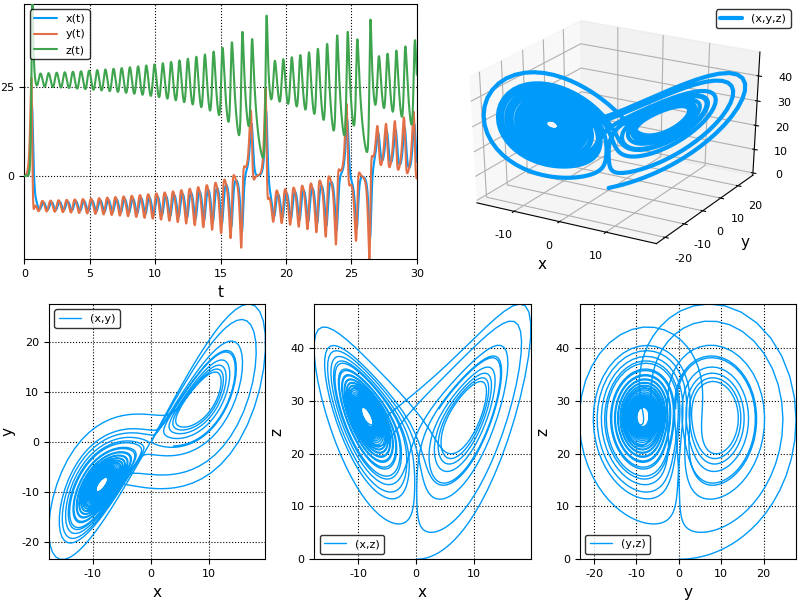

In [9]:
xyzt = plot(data_sol, plotdensity=10000,lw=1.5)
xy = plot(data_sol, plotdensity=10000, vars=(:x,:y))
xz = plot(data_sol, plotdensity=10000, vars=(:x,:z))
yz = plot(data_sol, plotdensity=10000, vars=(:y,:z))
xyz = plot(data_sol, plotdensity=10000, vars=(:x,:y,:z))
plot(plot(xyzt,xyz),plot(xy, xz, yz, layout=(1,3),w=1), layout=(2,1), size=(800,600))

In [10]:
# Note: Euler uses tstops to hit the estimation timepoints exactly since it's not adaptive
obj_short = build_loss_objective(prob_short,Euler(),L2Loss(t_short,data_short),tstops=t_short)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 11e3)
# Euler could not recover the correct results since its error is too high!

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps


0.50 secs, 824 evals, 678 steps, improv/step: 0.323 (last = 0.3230), fitness=4801.033865489
1.00 secs, 2522 evals, 2374 steps, improv/step: 0.281 (last = 0.2642), fitness=2887.452569260
1.50 secs, 4323 evals, 4176 steps, improv/step: 0.270 (last = 0.2558), fitness=2887.160913678
2.01 secs, 6147 evals, 6001 steps, improv/step: 0.264 (last = 0.2515), fitness=2887.159726403
2.51 secs, 7959 evals, 7813 steps, improv/step: 0.263 (last = 0.2588), fitness=2887.159725396
3.01 secs, 9819 evals, 9675 steps, improv/step: 0.260 (last = 0.2465), fitness=2887.159725395

Optimization stopped after 11001 steps and 3.3610000610351562 seconds
Termination reason: Max number of steps (11000) reached
Steps per second = 3273.1329366925975
Function evals per second = 3315.977327464685
Improvements/step = 0.2380909090909091
Total function evaluations = 11145


Best candidate found: [12.8306,26.6759,3.84562]

Fitness: 2887.159725395



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (11000) reached",11001,1.495286463871e9,3.3610000610351562,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(0.0,22.0),(0.0,60.0),(0.0,6.0)]),Pair{Symbol,Any}(:MaxSteps,11000),Pair{Symbol,Any}(:RngSeed,697004)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],11145,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(2887.1597253949885,[12.8306,26.6759,3.84562])

In [11]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short))
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 11e3)
# Tolernace is still too high to get close enough

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1453 evals, 1314 steps, improv/step: 0.311 (last = 0.3105), fitness=26.740258694
1.00 secs, 2913 evals, 2774 steps, improv/step: 0.294 (last = 0.2788), fitness=0.117591381
1.50 secs, 4370 evals, 4232 steps, improv/step: 0.286 (last = 0.2723), fitness=0.050842987
2.00 secs, 5870 evals, 5732 steps, improv/step: 0.282 (last = 0.2693), fitness=0.050585571
2.51 secs, 7335 evals, 7197 steps, improv/step: 0.259 (last = 0.1713), fitness=0.050583767
3.01 secs, 8803 evals, 8666 steps, improv/step: 0.229 (last = 0.0803), fitness=0.050583767
3.51 secs, 10260 evals, 10123 steps, improv/step: 0.203 (last = 0.0494), fitness=0.050583767

Optimization stopped after 11001 steps and 3.805999994277954 seconds
Termination reason: Ma

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (11000) reached",11001,1.495286472948e9,3.805999994277954,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(0.0,22.0),(0.0,60.0),(0.0,6.0)]),Pair{Symbol,Any}(:MaxSteps,11000),Pair{Symbol,Any}(:RngSeed,306910)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],11138,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(0.050583569926573174,[10.0082,27.9947,2.66844]

In [12]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),reltol=1e-9)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 8e3)
# With the tolerance lower, it achieves the correct solution in 3.5 seconds.

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1071 evals, 980 steps, improv/step: 0.305 (last = 0.3051), fitness=109.924452299
1.00 secs, 2175 evals, 2085 steps, improv/step: 0.280 (last = 0.2579), fitness=1.789697443
1.50 secs, 3280 evals, 3193 steps, improv/step: 0.270 (last = 0.2518), fitness=0.012989506
2.00 secs, 4390 evals, 4303 steps, improv/step: 0.271 (last = 0.2739), fitness=0.000057325
2.51 secs, 5508 evals, 5422 steps, improv/step: 0.274 (last = 0.2860), fitness=0.000000584
3.01 secs, 6613 evals, 6527 steps, improv/step: 0.272 (last = 0.2633), fitness=0.000000004
3.51 secs, 7740 evals, 7655 steps, improv/step: 0.277 (last = 0.3067), fitness=0.000000000

Optimization stopped after 8001 steps and 3.6710000038146973 seconds
Termination reason: Max 

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (8000) reached",8001,1.49528647978e9,3.6710000038146973,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(0.0,22.0),(0.0,60.0),(0.0,6.0)]),Pair{Symbol,Any}(:MaxSteps,8000),Pair{Symbol,Any}(:RngSeed,87495)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],8086,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(5.861449038941743e-11,[10.0,28.0,2.6666]),BlackBoxO

In [13]:
obj_short = build_loss_objective(prob_short,Vern7(),L2Loss(t_short,data_short),reltol=1e-9,abstol=1e-9)
res1 = bboptimize(obj_short;SearchRange = LooserBounds, MaxSteps = 7e3)
# With the more accurate solver Vern7 in the solution of the ODE, the convergence is less efficient!

# Fastest BlackBoxOptim: 3.5 seconds

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 383 evals, 290 steps, improv/step: 0.393 (last = 0.3931), fitness=876.089693301
1.00 secs, 747 evals, 651 steps, improv/step: 0.338 (last = 0.2936), fitness=251.985987030
1.50 secs, 1129 evals, 1033 steps, improv/step: 0.316 (last = 0.2775), fitness=4.711720741
2.01 secs, 1520 evals, 1424 steps, improv/step: 0.299 (last = 0.2558), fitness=4.288749029
2.51 secs, 1923 evals, 1828 steps, improv/step: 0.296 (last = 0.2871), fitness=1.660235981
3.01 secs, 2319 evals, 2225 steps, improv/step: 0.285 (last = 0.2343), fitness=0.385542384
3.51 secs, 2721 evals, 2627 steps, improv/step: 0.290 (last = 0.3159), fitness=0.059916529
4.01 secs, 3077 evals, 2983 steps, improv/step: 0.290 (last = 0.2865), fitness=0.000952129
4.51

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (7000) reached",7001,1.495286488426e9,9.202999830245972,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(0.0,22.0),(0.0,60.0),(0.0,6.0)]),Pair{Symbol,Any}(:MaxSteps,7000),Pair{Symbol,Any}(:RngSeed,948152)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],7091,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(1.6261995296723362e-11,[10.0,28.0,2.6666]),BlackBo

# Using NLopt

First, the global optimization algorithms

In [14]:
obj_short = build_loss_objective(prob_short,Tsit5(),L2Loss(t_short,data_short),reltol=1e-9)

(::DiffEqObjective) (generic function with 2 methods)

In [15]:
opt = Opt(:GN_ORIG_DIRECT_L, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate 1.8 seconds

  1.791007 seconds (4.21 M allocations: 412.837 MB, 4.69% gc time)


(5.629203434134945e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [16]:
opt = Opt(:GN_CRS2_LM, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate 1.55 seconds

  1.484746 seconds (3.47 M allocations: 341.773 MB, 4.71% gc time)


(5.6291816050761426e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [17]:
opt = Opt(:GN_ISRES, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Accurate to single precision 4.5 seconds

  4.448725 seconds (10.69 M allocations: 1.014 GB, 4.10% gc time)


(0.01412018292166803,[10.0034,28.0003,2.66657],:MAXEVAL_REACHED)

In [18]:
opt = Opt(:GN_ESCH, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximatively accurate, good starting values for local optimization

  4.315950 seconds (10.36 M allocations: 1.004 GB, 4.18% gc time)


(436.2098684349459,[9.53879,28.7947,2.62496],:MAXEVAL_REACHED)

Next, the local optimization algorithms that could be used after the global algorithms as a check on the solution and its precision. All the local optimizers are started from LocIniPar and with the narrow bounds of the Xiang2015Paper. 

In [19]:
opt = Opt(:LN_BOBYQA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar)
# There is a problem here. It declares SUCCESS even when there are instances of failure!

  0.068644 seconds (118.58 k allocations: 11.738 MB, 8.65% gc time)


(5.6291815151485e-11,[10.0,28.0,2.6666],:SUCCESS)

In [20]:
opt = Opt(:LN_NELDERMEAD, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.16 sec

  0.151078 seconds (317.22 k allocations: 31.270 MB, 3.64% gc time)


(5.629181316836434e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [21]:
opt = Opt(:LD_SLSQP, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.13 sec

  0.127355 seconds (195.07 k allocations: 17.952 MB, 9.29% gc time)


(5.629244629636958e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [22]:
opt = Opt(:LN_COBYLA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.64 sec

  0.624983 seconds (1.47 M allocations: 144.504 MB, 4.60% gc time)


(5.6291989100058776e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [23]:
opt = Opt(:LN_NEWUOA_BOUND, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.15 sec ROUNDOFF LIMITED

  0.146183 seconds (231.20 k allocations: 22.796 MB, 4.40% gc time)


(2.6521029889697497e-9,[10.0,28.0,2.6666],:ROUNDOFF_LIMITED)

In [24]:
opt = Opt(:LN_PRAXIS, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.14 sec

  0.153237 seconds (330.04 k allocations: 32.864 MB, 2.76% gc time)


(5.6291816828287156e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [25]:
opt = Opt(:LN_SBPLX, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.5 sec

  0.510961 seconds (1.11 M allocations: 109.575 MB, 4.73% gc time)


(5.629182873112082e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [26]:
opt = Opt(:LD_MMA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.3 sec

  0.297520 seconds (667.01 k allocations: 65.703 MB, 4.28% gc time)


(5.629194048727783e-11,[10.0,28.0,2.6666],:XTOL_REACHED)

In [27]:
opt = Opt(:LD_LBFGS, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.08 sec

  0.078134 seconds (139.34 k allocations: 13.721 MB, 8.43% gc time)


(5.629245700359239e-11,[10.0,28.0,2.6666],:SUCCESS)

In [28]:
opt = Opt(:LD_TNEWTON_PRECOND_RESTART, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj_short.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Accurate 0.09 sec

  0.090407 seconds (168.70 k allocations: 16.610 MB, 8.02% gc time)


(5.629245157529216e-11,[10.0,28.0,2.6666],:SUCCESS)


## Now let's solve the longer version

Notice from the plotting above that this ODE problem is chaotic and tends to diverge over time. In the longer version of parameter estimation, the dataset is increased to 3000 observations per variable with the same integration time step of 0.01.

In [29]:
obj = build_loss_objective(prob,Euler(),L2Loss(t,data),tstops=t)
res1 = bboptimize(obj;SearchRange = LooserBounds, MaxSteps = 4e3)
# Once again, Euler fails to converge. Error cannot be reduced.

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps


0.50 secs, 226 evals, 140 steps, improv/step: 0.436 (last = 0.4357), fitness=747975.048205833


1.01 secs, 474 evals, 365 steps, improv/step: 0.340 (last = 0.2800), fitness=747975.048205833
1.51 secs, 715 evals, 602 steps, improv/step: 0.309 (last = 0.2616), fitness=747975.048205833
2.01 secs, 958 evals, 838 steps, improv/step: 0.284 (last = 0.2203), fitness=747975.048205833
2.51 secs, 1206 evals, 1083 steps, improv/step: 0.267 (last = 0.2082), fitness=747975.048205833
3.01 secs, 1453 evals, 1330 steps, improv/step: 0.241 (last = 0.1255), fitness=747975.048205833
3.51 secs, 1704 evals, 1581 steps, improv/step: 0.224 (last = 0.1355), fitness=747975.048205833
4.01 secs, 1955 evals, 1832 steps, improv/step: 0.207 (last = 0.0996), fitness=747975.048205833
4.52 secs, 2207 evals, 2084 steps, improv/step: 0.210 (last = 0.2341), fitness=747975.048205833
5.02 secs, 2457 evals, 2334 steps, improv/step: 0.204 (last = 0.1480), fitness=747975.048205833
5.52 secs, 2704 evals, 2581 steps, improv/step: 0.203 (last = 0.1984), fitness=747975.048205833
6.02 secs, 2952 evals, 2829 steps, improv/step

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (4000) reached",4001,1.495286540711e9,8.539000034332275,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(0.0,22.0),(0.0,60.0),(0.0,6.0)]),Pair{Symbol,Any}(:MaxSteps,4000),Pair{Symbol,Any}(:RngSeed,403090)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],4124,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(747975.048205833,[9.23435,24.1499,0.214224]),Black

In [30]:
obj = build_loss_objective(prob,Tsit5(),L2Loss(t,data),reltol=1e-9)
res1 = bboptimize(obj;SearchRange = LooserBounds, MaxSteps = 20e3)
# BB with Tsit5 converges very slowly. The final values are within the NarrowBounds.

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 163 evals, 99 steps, improv/step: 0.313 (last = 0.3131), fitness=514593.322545953
1.01 secs, 289 evals, 192 steps, improv/step: 0.339 (last = 0.3656), fitness=514593.322545953
1.51 secs, 471 evals, 353 steps, improv/step: 0.329 (last = 0.3168), fitness=502195.038990115
2.01 secs, 654 evals, 524 steps, improv/step: 0.313 (last = 0.2807), fitness=495214.676975930
2.52 secs, 840 evals, 701 steps, improv/step: 0.304 (last = 0.2768), fitness=481639.668628374
3.02 secs, 1025 evals, 882 steps, improv/step: 0.282 (last = 0.1989), fitness=471175.034533584
3.52 secs, 1205 evals, 1061 steps, improv/step: 0.282 (last = 0.2793), fitness=467351.818910919
4.02 secs, 1385 evals, 1241 steps, improv/step: 0.274 (last = 0.2278), f

41.67 secs, 13310 evals, 13169 steps, improv/step: 0.111 (last = 0.1420), fitness=257591.417227341
42.17 secs, 13469 evals, 13328 steps, improv/step: 0.112 (last = 0.1384), fitness=257591.417227341
42.67 secs, 13632 evals, 13491 steps, improv/step: 0.113 (last = 0.1718), fitness=257591.403012456
43.17 secs, 13794 evals, 13653 steps, improv/step: 0.113 (last = 0.1481), fitness=257591.403012456
43.68 secs, 13955 evals, 13814 steps, improv/step: 0.113 (last = 0.1491), fitness=257591.399684758
44.18 secs, 14117 evals, 13976 steps, improv/step: 0.114 (last = 0.1543), fitness=257591.399240133
44.68 secs, 14275 evals, 14134 steps, improv/step: 0.114 (last = 0.1266), fitness=257591.399240133
45.18 secs, 14437 evals, 14296 steps, improv/step: 0.115 (last = 0.1728), fitness=257591.399240133
45.68 secs, 14597 evals, 14456 steps, improv/step: 0.115 (last = 0.1250), fitness=257591.399208129
46.19 secs, 14759 evals, 14618 steps, improv/step: 0.115 (last = 0.1296), fitness=257591.398884192
46.69 secs

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (20000) reached",20001,1.495286551487e9,63.69799995422363,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(0.0,22.0),(0.0,60.0),(0.0,6.0)]),Pair{Symbol,Any}(:MaxSteps,20000),Pair{Symbol,Any}(:RngSeed,571638)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],20138,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(257591.39876878046,[11.3712,25.7339,2.77643]),

In [31]:
opt = Opt(:GN_ORIG_DIRECT_L, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Fail to converge 

  3.131022 seconds (6.81 M allocations: 942.175 MB, 5.19% gc time)


(426905.80801953137,[7.74577,23.3471,2.11067],:XTOL_REACHED)

In [32]:
opt = Opt(:GN_CRS2_LM, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Fail to converge approximately accurate vales for local opt.29.48 seconds

 29.214350 seconds (67.10 M allocations: 8.433 GB, 4.28% gc time)


(332266.227143373,[11.3266,24.206,2.44207],:MAXEVAL_REACHED)

In [33]:
opt = Opt(:GN_ISRES, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 50000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximately accurate within local bounds

151.037999 seconds (345.61 M allocations: 42.465 GB, 4.31% gc time)


(289007.1902066829,[12.5475,25.3048,2.60214],:MAXEVAL_REACHED)

In [34]:
opt = Opt(:GN_ESCH, 3)
lower_bounds!(opt,[0.0,0.0,0.0])
upper_bounds!(opt,[22.0,60.0,6.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,GloIniPar) # Approximately accurate

 27.778938 seconds (63.22 M allocations: 8.317 GB, 4.43% gc time)


(376294.4562761503,[12.593,24.8745,2.5139],:MAXEVAL_REACHED)

This parameter estimation on the longer sample proves to be extremely challenging for the global optimizers. BlackBoxOptim is best in optimizing the objective function. All of the global algorithms produces final parameter estimates that could be used as starting values for further refinement with the local optimization algorithms.

In [35]:
opt = Opt(:LN_BOBYQA, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Claims SUCCESS but does not iterate to the true values.

  0.298980 seconds (616.62 k allocations: 84.691 MB, 4.37% gc time)


(514525.487503247,[11.0,22.2033,2.21942],:SUCCESS)

In [36]:
opt = Opt(:LN_NELDERMEAD, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-9)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Inaccurate final values

  7.834270 seconds (17.75 M allocations: 2.333 GB, 4.40% gc time)


(370938.4515083501,[9.0,23.5009,2.18295],:XTOL_REACHED)

In [37]:
opt = Opt(:LD_SLSQP, 3)
lower_bounds!(opt,[9.0,20.0,2.0])
upper_bounds!(opt,[11.0,30.0,3.0])
min_objective!(opt, obj.cost_function2)
xtol_rel!(opt,1e-12)
maxeval!(opt, 10000)
@time (minf,minx,ret) = NLopt.optimize(opt,LocIniPar) # Inaccurate final values

  0.078957 seconds (144.38 k allocations: 18.898 MB, 6.75% gc time)


(540477.1870112764,[9.43171,22.1585,2.21585],:XTOL_REACHED)

No local optimizer can improve the global solution to the true values.

# Conclusion:

 1) To benchmark parameter estimators, make sure the synthetic data is correct.
    The lorenz_test.jl results are all skewed because the actual Euler solution
    producing the synthetic data was skewed. Euler being a fixed timestep, it was able
    to rediscover the parameters that built the data, given that it's hitting all the
    same points. In this experiemnt this is no longer the case. There is adaptive timestepping with Vern7,
    we're getting rid of the ability to "overfit", i.e. simply match the data
    we generated. Instead, we have to hit the same solution, albeit at different
    stepping points, making it less prone to generating bias.
    
 2) As expected the Lorenz system is extremely sensitive to initial space values. 
    Starting the integration from r0 = [0.1,0.0,0.0] produces convergence with the short
    sample of 300 observations. This can be achieved by all the global optimizers as well as most of the local optimizers. 
    Instead starting from r0= [-11.8,-5.1,37.5], as in PODES, with the shorter sample shrinks
    the number of successful algorithms to 3: BBO, :GN_CRS2_LM and :LD_SLSQP. For the longer sample, all the algorithms fail.
    THIS IS A FAILURE OF THE NONLINEAR LEAST SQUARES ESTIMATOR L2LOSS.
    
 3) When trying to hit the real data, having a low enough tolerance on the
    numerical solution is key. If the numerical solution is too rough, then
    we can never actually hone in on the true parameters since even with the
    true parameters we will erroneously induce numerical error. Maybe this
    could be adaptive?
    
 4) Excessively low tolerance in the numerical solution is inefficient and delays the convergence of the estimation.
 
 5) The estimation method and the glocal versus local optimization make a huge difference in the timings. Here, BBO
    always find the correct solution for a global optimization setup. For local optimization, most methods in NLopt,
    like :LN_BOBYQA, solve the problem in <0.05 seconds. This is an algorithm that can scale a local optimization
    but we are aiming to scale a global optimization.
    
 6) Fitting shorter timespans is easier... maybe this can lead to determining a minimal sample size for the 
    optimizers and the estimator to succeed.